In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tifffile as tiff
import json
import pyproj
from PIL import Image,ImageDraw
import json

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import sys
import shutil
import pandas as pd

from torch.utils.data import Dataset
import xml.etree.ElementTree as et
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn


import time
from matplotlib.patches import Rectangle
import segmentation_models_pytorch as smp
from torch.cuda import amp
from collections import defaultdict
import copy
import random



import albumentations as A # optimizer https://hoya012.github.io/blog/albumentation_tutorial/

# 25cm, 0.25m 는 25*25 사이즈의 크기가 점으로 표현 가능한 해상도를 뜻함함
# tiff 데이터는 np.array 로 넘파이화 시키면 될듯

c:\Users\LG\anaconda3\envs\sw_acp\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.19 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [501]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


COLOR=[[255,0,0],
       [255,50,0],
       [255,255,0],
       [0,255,0],
       [0,0,255],
       [0,5,255],
       [100,0,255],
       [255,192,203],
       [101,67,33],
       [0,86,102]
       ]
class_name=["건물",
            "주차장","비닐하우스",
            "나지","도로","가로수",
            "밭","산림","농경지","비대상지"]

def path(type,name,size):
	if type=="image":
		return f"C:/Cdrive/Ddrive/study/sw_acp/refine_data/{size}/{type}/{name}.npy"
	else:
		return f"C:/Cdrive/Ddrive/study/sw_acp/refine_data/{size}/{type}/{name}/{name}.npy"

def Synthesis_img_mask(name="LC_JJ_AP25_33606070_015_2019_FGT",idxs=[4],size=1024): # 0<=idx<=9
	PATH = path("image",name,size)
	img = np.load(PATH)
	img = np.transpose(img,(2,0,1))
	print(img.shape)
 
	IMG = Image.fromarray(img[0]*255).convert("RGB")
	IMG = np.array(IMG)
	synthesis = IMG


	PATH1 = path("mask",name,size)
	mask = np.load(PATH1)
	mask = np.transpose(mask,(2,0,1))
 
	exist =[0]*10
 
	for idx in idxs:
		mask2=np.array(mask,"float32")[idx]
		mask2 = np.array(Image.fromarray(mask2*255).convert("RGB"))
  
		if np.max(mask2)>0:
			exist[idx]=1

		mask2[:,:,0][mask2[:,:,0]!=0]=COLOR[idx][0]
		mask2[:,:,1][mask2[:,:,1]!=0]=COLOR[idx][1]
		mask2[:,:,2][mask2[:,:,2]!=0]=COLOR[idx][2]

		synthesis[mask2[:,:,0]!=0]=np.array(COLOR[idx])
		synthesis[mask2[:,:,1]!=0]=np.array(COLOR[idx])
		synthesis[mask2[:,:,2]!=0]=np.array(COLOR[idx])

	mask3 = Image.fromarray(synthesis).convert("RGB")
 
		
	plt.imshow(mask3)
	handles = []
	labels = []
	for i in range(10):
		if exist[i]:
			handles.append(Rectangle((0,0),1,1, color=tuple([COLOR[i][j]/255 for j in range(3)])))
			labels.append(class_name[i])
         
 
	plt.legend(handles,labels)
	plt.axis('off')

(10, 1024, 1024)


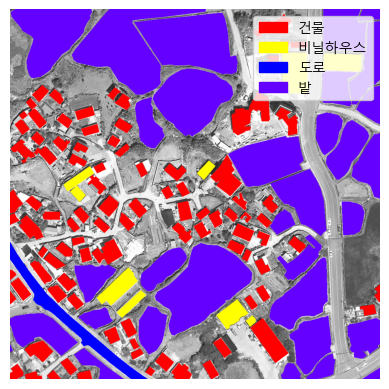

In [506]:
Synthesis_img_mask(name="LC_JJ_AP25_33606083_015_2019_FGT",
                   idxs=[i for i in range(10)],size=1024)

In [430]:
img.shape

(10, 1024, 1024)

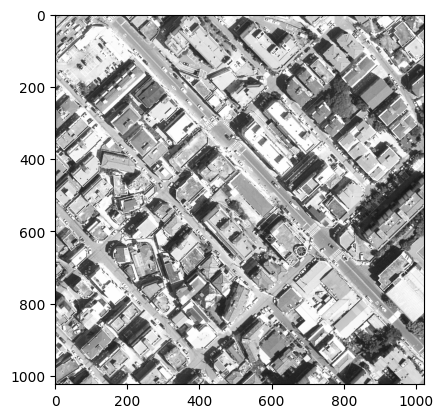

In [431]:
img2 = Image.fromarray(img[0]*255).convert("RGBA")
plt.imshow(img2)

In [432]:
PATH1 = path("mask","LC_JJ_AP25_33606070_015_2019_FGT")
mask = np.load(PATH1)
mask = np.transpose(mask,(2,0,1))

In [433]:
mask.shape

(10, 1024, 1024)

In [434]:
mask

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [435]:
np.max(mask[9])

0

In [436]:
mask2=np.array(mask,"float32")[0]

#mask2 = np.transpose(mask2,(2,0,1))

In [437]:
mask2.shape

(1024, 1024)

In [438]:
np.max(mask2)

1.0

In [439]:
mask2 = np.array(Image.fromarray(mask2*255).convert("RGB"))

In [440]:
mask2.shape

(1024, 1024, 3)

In [441]:
np.max(mask2)

255

In [442]:
np.max(mask2[:,:,2])

255

In [443]:
mask2[:,:,0][mask2[:,:,0]!=0]=0
mask2[:,:,1][mask2[:,:,1]!=0]=0
mask2[:,:,2][mask2[:,:,2]!=0]=255

In [444]:
mask2[:,:][mask2[:,:]!=255]=0

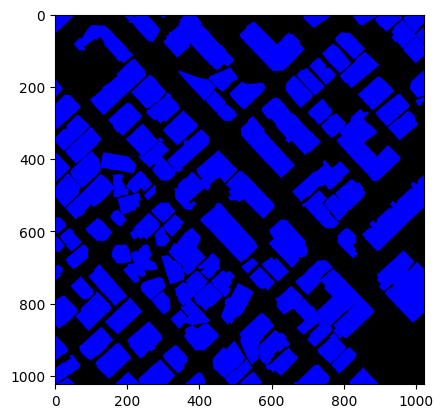

In [445]:
mk3 = Image.fromarray(mask2)
plt.imshow(mk3)

In [446]:
IMG = Image.fromarray(img[0]*255).convert("RGB")
IMG = np.array(IMG)

In [447]:
IMG.shape

(1024, 1024, 3)

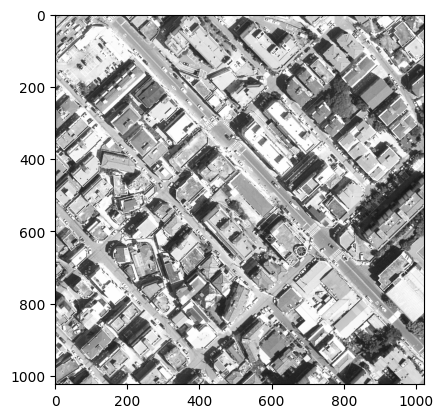

In [448]:
mk=Image.fromarray(IMG)
plt.imshow(mk)

In [449]:
synthesis = IMG
synthesis[mask2[:,:,2]==255]=np.array([0,0,255])

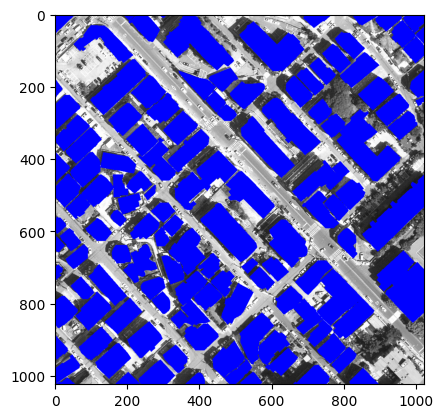

In [450]:
mask3 = Image.fromarray(synthesis).convert("RGB")
plt.imshow(mask3)

In [451]:
""" classes = {"건물":[],"주차장":[],"비닐하우스":[],"나지":[],"도로":[],"가로수":[],"밭":[],"산림":[],"농경지":[],"비대상지":[]}
Q = preds[0][4]
#for i in range(1,10):
#    Q+=preds[0][i]
    
Q[Q>1]=1
img_2 = Image.fromarray(Q*255) # NumPy array to PIL image
plt.imshow(img_2) """

' classes = {"건물":[],"주차장":[],"비닐하우스":[],"나지":[],"도로":[],"가로수":[],"밭":[],"산림":[],"농경지":[],"비대상지":[]}\nQ = preds[0][4]\n#for i in range(1,10):\n#    Q+=preds[0][i]\n    \nQ[Q>1]=1\nimg_2 = Image.fromarray(Q*255) # NumPy array to PIL image\nplt.imshow(img_2) '